In [1]:
%matplotlib inline 
#%load_ext autoreload 
%reload_ext autoreload
%autoreload 2
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from __future__ import (division, 
                        print_function)

import os
import sys
import copy

import h5py
import numpy as np
import scipy
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel


import matplotlib as mpl
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 
mpl.rcParams.update({'xtick.color': 'k'})
mpl.rcParams.update({'ytick.color': 'k'})
mpl.rcParams.update({'font.size': 20})

import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)


import sys
sys.path.append('/Users/RAJ/github/kungpao')
from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap
import statsmodels.api as sm
from scipy.interpolate import interp1d 
from kungpao import io
from kungpao import utils
from kungpao import detection
from kungpao import imtools

import sep
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/pyraf/irafimport.py:116: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  retval = _originalImport(name, globals, locals, fromlist, level)


In [2]:
from __future__ import (print_function, division, absolute_import)

import os
import copy
import glob
import warnings
import subprocess

import pickle 

import numpy as np

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar

In [3]:
from astropy.modeling import models, fitting

In [4]:
x_images = '/Users/RAJ/anaconda/envs/illustris_profiles/iraf/bin.macosx/x_images.e'
TBL = '/Users/RAJ/anaconda/envs/illustris_profiles/iraf_extern/tables/bin.macosx/x_ttools.e'
ISO = '/Users/RAJ/anaconda/envs/illustris_profiles/iraf_extern/stsdas/bin.macosx/x_isophote.e'

In [5]:
illustris_dir = '/Users/RAJ/Work/illustris'
illustris_hdf5 = os.path.join(illustris_dir, 'galaxies_orig_11.2.hdf5')

illustris_file = h5py.File(illustris_hdf5, 'r')

cat_sh_mstar = np.array(illustris_file['cat_sh_mstar'])
cat_sh_mdm = np.array(illustris_file['cat_sh_mdm'])
cat_sh_mbh = np.array(illustris_file['cat_sh_mbh'])

pixel_scale = 5.0  # kpc/pixel

map_size = 500.0  # kpc
n_pixels = 200    # pixels

In [6]:
illustris_ellip = np.load(os.path.join(illustris_dir, 'illustris_0_ell.npy'))

In [7]:
illustris_0_cen_aper = np.load(os.path.join(illustris_dir, 'illustris_0_cen_aper.npy'))
illustris_0_ins_aper = np.load(os.path.join(illustris_dir, 'illustris_0_ins_aper.npy'))
illustris_0_exs_aper = np.load(os.path.join(illustris_dir, 'illustris_0_exs_aper.npy'))

In [8]:
logms_cat = np.log10(cat_sh_mstar)
logmh_cat = np.log10(cat_sh_mdm)

In [9]:
def get_median_prof(ellips, kind='ell_cen_3', pixel_scale=5.0,
                    rmin=0.05, rmax=4.7, nbin=150):
    """Get the median profiles."""
    rsma_common = np.linspace(rmin, rmax, nbin)
    
    
    return np.nanmedian(np.stack([interp1d((gal[kind]['sma'] * pixel_scale) ** 0.25 , 
                                           np.log10(gal[kind]['intens'] / (pixel_scale ** 2)),
                                           bounds_error=False, 
                                           fill_value=np.nan, 
                                           kind='slinear')(rsma_common) 
                           for gal in ellips]), axis=0)

In [12]:
mask_exs_4 = np.asarray([ell['ell_exs_4'] is not None for ell in illustris_ellip])
mask_bin1 = ((logms_cat >= 11.4) & (logms_cat < 11.435) & mask_exs_4) 
rsma_prof = np.linspace(0.05, 4.7, 150)

In [14]:
prof_ins_bin_1 = get_median_prof(illustris_ellip[mask_bin1], kind='ell_ins_4')

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


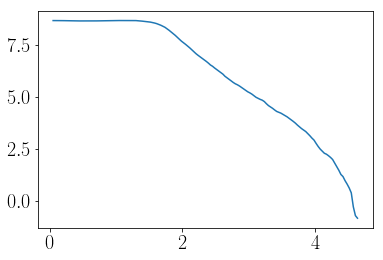

In [15]:
plt.plot(rsma_prof,prof_ins_bin_1)

In [16]:
mask = ((rsma_prof >= 1.7) & (rsma_prof <= 3.8))

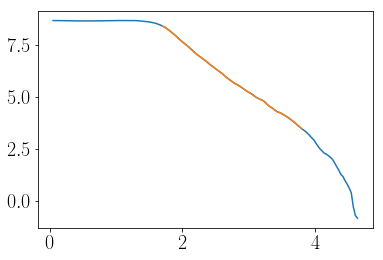

In [17]:
plt.plot(rsma_prof,prof_ins_bin_1)
plt.plot(rsma_prof[mask],prof_ins_bin_1[mask])

In [18]:
sersic_mod = models.Sersic1D(amplitude=3., r_eff=4, n=1)
sersic_prof = sersic_mod(rsma_prof)

(0, 10)

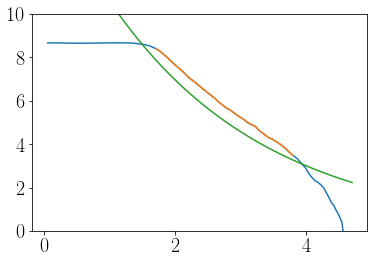

In [19]:
plt.plot(rsma_prof,prof_ins_bin_1)
plt.plot(rsma_prof[mask],prof_ins_bin_1[mask])
plt.plot(rsma_prof,(sersic_prof))
#plt.xlim(1,4)
plt.ylim(0,10)

In [20]:
sersic_1 = models.Sersic1D(amplitude=3.0, r_eff=4., n=1.)
sersic_fit = fitting.LevMarLSQFitter()
gal_sma = np.asarray(rsma_prof[mask])
gal_intens = np.asarray(prof_ins_bin_1[mask])
sersic_best = sersic_fit(sersic_1, gal_sma, gal_intens)


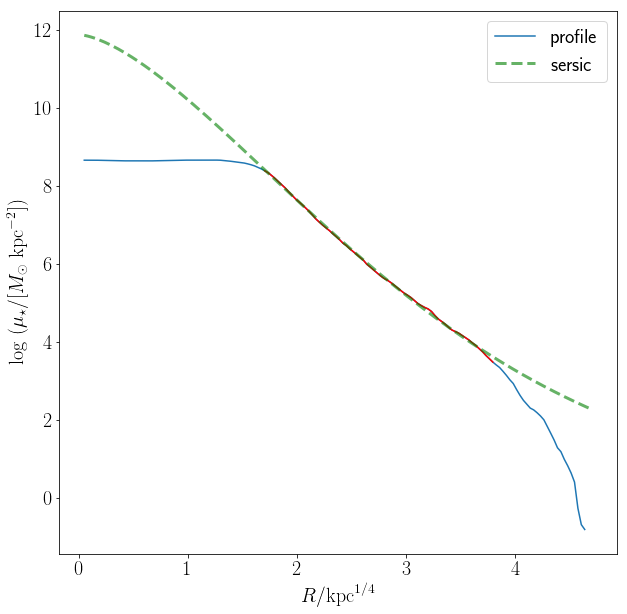

In [22]:
plt.figure(figsize=(10,10))
plt.plot(rsma_prof,prof_ins_bin_1,label='profile')

plt.plot(rsma_prof[mask],prof_ins_bin_1[mask],c='r')
plt.plot(rsma_prof,(sersic_best(rsma_prof)),c='g',alpha=0.6,linestyle='--',label='sersic',linewidth=3)


plt.xlabel(r'$R/\mathrm{kpc}^{1/4}$', fontsize=20)
plt.ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$',
               fontsize=20)
plt.legend()
#plt.savefig('sersic1_fit_bin1_ins.png')